In [2]:
# Copyright 2025 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Foundations of Inference
<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/inardini/gcp-nvidia-community-ai-inference-lp/blob/main/learning_path_01/01_foundations_of_inference.ipynb">
      <img width="32px" src="https://www.gstatic.com/pantheon/images/bigquery/welcome_page/colab-logo.svg" alt="Google Colaboratory logo"><br> Open in Colab
    </a>
  </td>
</table>

<div style="clear: both;"></div>

<p>
<b>Share to:</b>

<a href="https://www.linkedin.com/sharing/share-offsite/?url=https%3A//github.com/inardini/gcp-nvidia-community-ai-inference-lp/blob/main/learning_path_01/01_foundations_of_inference.ipynb" target="_blank">
  <img width="20px" src="https://upload.wikimedia.org/wikipedia/commons/8/81/LinkedIn_icon.svg" alt="LinkedIn logo">
</a>

<a href="https://bsky.app/intent/compose?text=https%3A//github.com/inardini/gcp-nvidia-community-ai-inference-lp/blob/main/learning_path_01/01_foundations_of_inference.ipynb" target="_blank">
  <img width="20px" src="https://upload.wikimedia.org/wikipedia/commons/7/7a/Bluesky_Logo.svg" alt="Bluesky logo">
</a>

<a href="https://twitter.com/intent/tweet?url=https%3A//github.com/inardini/gcp-nvidia-community-ai-inference-lp/blob/main/learning_path_01/01_foundations_of_inference.ipynb" target="_blank">
  <img width="20px" src="https://upload.wikimedia.org/wikipedia/commons/5/5a/X_icon_2.svg" alt="X logo">
</a>

<a href="https://reddit.com/submit?url=https%3A//github.com/inardini/gcp-nvidia-community-ai-inference-lp/blob/main/learning_path_01/01_foundations_of_inference.ipynb" target="_blank">
  <img width="20px" src="https://redditinc.com/hubfs/Reddit%20Inc/Brand/Reddit_Logo.png" alt="Reddit logo">
</a>

<a href="https://www.facebook.com/sharer/sharer.php?u=https%3A//github.com/inardini/gcp-nvidia-community-ai-inference-lp/blob/main/learning_path_01/01_foundations_of_inference.ipynb" target="_blank">
  <img width="20px" src="https://upload.wikimedia.org/wikipedia/commons/5/51/Facebook_f_logo_%282019%29.svg" alt="Facebook logo">
</a>
</p>

# Overview

This notebook introduces the **fundamental concepts of model inference** — how a trained model takes an input and produces an output.  

We will build a step-by-step understanding of the inference pipeline:

- **CPU vs GPU inference** — showing why hardware acceleration matters.  
- **Inference pipeline** — preprocessing, batching & padding, forward pass, decoding, and postprocessing.  

The focus here is on clarity and education: we use a small model so you can see the mechanics of inference clearly before moving to larger and more optimized setups.

## Preliminaries

**Before you begin**, make sure you have:

- An NVIDIA GPU environment
- Access to the gated [Gemma 3 270M](https://huggingface.co/google/gemma-3-270m) or [Gemma 3 270M Instruction-Tuned](https://huggingface.co/google/gemma-3-270m-it) model on Hugging Face
- Your Hugging Face [access token](https://huggingface.co/settings/token)

Let's test which GPUs are available in our system:

In [4]:
!nvidia-smi

Mon Dec  1 23:31:19 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   64C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Authenticating with Hugging Face

To download the model from Hugging Face, you’ll need to enter your personal access token.

The cell below provides a simple interface to enter and save your token securely. It will be cached locally, so you only need to do this once per environment.

➡️ You can find or generate your token at: [https://huggingface.co/settings/tokens](https://huggingface.co/settings/tokens)

Once saved, the token will allow seamless access to gated models like `google/gemma-3-270m`.

In [5]:
# ⬇️ Run this cell once
from ipywidgets import Password, Button, HBox, Output
import os, pathlib
import sys

from huggingface_hub import HfFolder, whoami

# ---- UI widgets ----
token_box = Password(
    description="HF Token:",
    placeholder="paste your Hugging Face token here",
    layout={"width": "450px"},
)
save_btn = Button(description="Save", button_style="success")
out = Output()

# ---- Callback ----
def save_token(_):
    out.clear_output()
    token = token_box.value.strip()
    with out:
        if not token:
            print("❌ No token entered.")
            return
        # Persist token
        HfFolder.save_token(token)                 # writes to ~/.cache/huggingface/token
        os.environ["HF_TOKEN"] = token             # current kernel env (optional)
        # Sanity-check who we are
        try:
            user = whoami(token)["name"]
            print(f"✅ Token saved. Logged in as: {user}")
        except Exception as e:
            print("⚠️ Token saved, but user lookup failed:", e)

save_btn.on_click(save_token)

display(HBox([token_box, save_btn]), out)

Output()

## Training vs inference

In machine learning, the lifecycle of a model can be divided into two primary phases: **training** and **inference**. During training, the model learns to identify patterns and relationships within the data. This process involves a **forward pass**, where input data is propagated through the network to generate predictions, followed by a **backward pass**, in which gradients of a loss function with respect to the model parameters are computed. An **optimizer** then uses these gradients to adjust the model parameters iteratively, minimizing the loss and improving the model’s predictive accuracy.

Once training is complete, the model enters the inference phase, where it is used to make predictions on new, unseen data. Inference is simpler than training because it involves only the forward pass; the model parameters are fixed and no learning occurs.

*Inference is the process of using a trained model to generate outputs for new inputs without any learning or weight updates.*

For large language models (LLMs), this means:

- Receiving a prompt (a string of text).
- Computing the most likely next token(s).
- Repeating the process token-by-token to generate a full response.

Inference is the core of every production LLM system — whether you’re building a chatbot, writing assistant, summarizer, or anything else.

### Why do we need GPUs for inference?

You may have heard that we need a GPU to run AI inference. Why is so? To answer this question let's run a simple experiment.

Let's first download our model. We wil be using the model [Gemma 3 270M Instruction-Tuned](https://huggingface.co/google/gemma-3-270m-it) by Google. Before you continue, make sure to open the [model page](https://huggingface.co/google/gemma-3-270m-it) and accept the terms of usage agreement.

In [6]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
import time, numpy as np


# Helper function to measure inference time
def timed_generate(model, tokenizer, prompts, device, max_new_tokens=64, runs=5):
    enc = tokenizer(prompts, padding=True, return_tensors="pt").to(device)
    times = []
    with torch.inference_mode():
        for _ in range(runs):
            t0 = time.perf_counter()
            _ = model.generate(**enc, max_new_tokens=max_new_tokens)
            if device == "cuda":
                torch.cuda.synchronize()
            times.append(time.perf_counter() - t0)
    lat = np.array(times)
    return lat

MODEL_ID = "google/gemma-3-270m-it"

# Make sure you've entered your Hugging Face token above
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
# Ensure we have a pad token for batching
if tokenizer.pad_token is None and tokenizer.eos_token is not None:
    tokenizer.pad_token = tokenizer.eos_token

# Load model on CPU
model_cpu = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    dtype=torch.float32,
    device_map={"": "cpu"}
).eval()

# Load model directly on GPU
model_gpu = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    dtype=torch.bfloat16 if torch.cuda.is_bf16_supported() else torch.float16,
    device_map="cuda"   # puts all weights on the GPU
).eval()

print("CUDA available:", torch.cuda.is_available())

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


CUDA available: True


#### CPU baseline

Let's start with the CPU baseline. We will execute our inference several times using a simple prompt and measure execution times.

In [7]:
prompt = "Explain inference vs training in one sentence."
batch = [prompt]

cpu_lat = timed_generate(model_cpu, tokenizer, batch, device="cpu")
print("CPU execution times:", cpu_lat)
print("CPU median execution time:", np.median(cpu_lat), "s")



Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


CPU execution times: [9.73765842 9.79396093 9.10583803 9.77304972 9.75189543]
CPU median execution time: 9.751895434000062 s


#### Executing on GPU

Now we will do the same procedure, but on the GPU. We will be using the same prompt and batch.

In [8]:
prompt = "Explain inference vs training in one sentence."
batch = [prompt]

if torch.cuda.is_available():
    gpu_lat = timed_generate(model_gpu, tokenizer, batch, device="cuda")
    print("GPU execution times:", gpu_lat)
    print("GPU median execution time:", np.median(gpu_lat), "s")
else:
    print("No CUDA device available")

Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


GPU execution times: [6.2243564  8.22735293 8.87705789 3.30387125 2.43182257]
GPU median execution time: 6.224356403999991 s


#### Side-by-side latency plot

**Latency** is the time it takes for a system to return a result after receiving a request.

In inference, it is measured as the **time from when a prompt is submitted until the model produces a complete output (or the first token, if streaming)**.

- Lower latency → faster response → better user experience.  
- Higher latency → longer wait times → degraded user experience.

So, in our experiments, latency is the execution time we've measured.

Let's compare CPU and GPU latencies side-by-side!

/tmp/ipython-input-1732297588.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([cpu_lat, gpu_lat], labels=["CPU","GPU"])


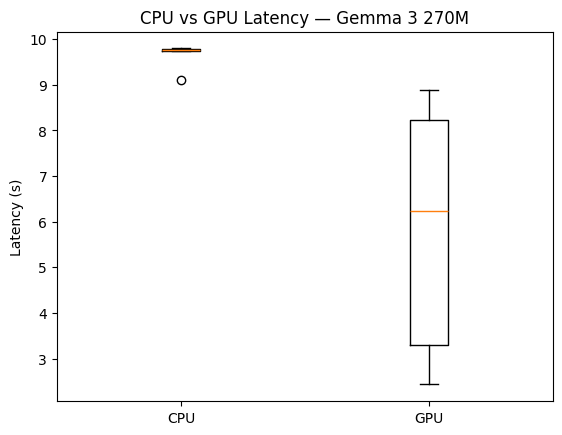

In [9]:
import matplotlib.pyplot as plt

plt.boxplot([cpu_lat, gpu_lat], labels=["CPU","GPU"])
plt.ylabel("Latency (s)")
plt.title("CPU vs GPU Latency — Gemma 3 270M")
plt.show()

What you should be able to see here is that on average GPU latencies are lower than CPU latencies. Some outliers are possible, but what matters is the median value.

Note that Gemma 3 270M is a lightweight model and this difference would be more drammatic on bigger models.

#### Why is GPU inference faster?

GPUs are designed to handle thousands of operations in parallel, while CPUs typically focus on fewer tasks in sequence.  

During inference, LLMs perform a huge number of matrix multiplications — operations that map perfectly onto the GPU’s parallel architecture.  

- **Parallelism:** A GPU has thousands of cores that can process many elements of a matrix at once, whereas a CPU has far fewer cores optimized for general tasks.  
- **Throughput:** This parallelism lets GPUs achieve much higher throughput, meaning they can process larger batches of tokens or requests efficiently.  
- **Specialized hardware:** Modern GPUs also include optimized libraries and hardware features (like Tensor Cores) that accelerate deep learning operations far beyond what CPUs can achieve.  

The result is that the same model produces responses **orders of magnitude faster** on a GPU than on a CPU — which directly improves user experience.

## Inference pipeline and its components

When we talk about *inference*, we mean the process of turning an input prompt into an output sequence.  

The pipeline has four main components:

1. **Preprocessing** – tokenize text into IDs the model understands.  
2. **Batching & padding** – pack multiple requests together for efficiency.  
3. **Forward pass + decoding** – model computes logits, selects tokens step by step (with KV-cache for efficiency).  
4. **Postprocessing** – convert token IDs back into human-readable text.  

### Preprocessing (tokenization) and batching & padding

In this example, we pass **two prompts of very different lengths** to the tokenizer.  

Because models expect inputs to be rectangular tensors, all sequences in a batch must have the **same length**.  

- The **short prompt** `"Hi"` becomes just a couple of tokens.  
- The **long prompt** expands to many tokens.  
- To align them into the same tensor, the tokenizer **pads the shorter input** with zeros at the end.  

The result:  
- `input_ids` → contains both the real token IDs and padding tokens (0).  
- `attention_mask` → uses `1` to mark real tokens and `0` to mark padding positions, so the model ignores padding during computation.  

This way, both prompts can be processed **in parallel** on the GPU, even though they originally had different lengths.

In [10]:
# Prompts (batch of 2)
prompts = [
    "Hi",
    "Explain in detail what AI model training means and why it is important."
]

# Tokenize on CPU (cheap)
encodings = tokenizer(prompts, padding=True, truncation=True, return_tensors="pt")

print("input_ids shape:", encodings["input_ids"].shape)
print("attention_mask shape:", encodings["attention_mask"].shape)

print("Batch size:", encodings["input_ids"].shape[0])
print("Sequence length (after padding):", encodings["input_ids"].shape[1])

# Inspect the raw values
print("\ninput_ids[0]:", encodings["input_ids"][0].tolist())
print("attention_mask[0]:", encodings["attention_mask"][0].tolist())

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


input_ids shape: torch.Size([2, 15])
attention_mask shape: torch.Size([2, 15])
Batch size: 2
Sequence length (after padding): 15

input_ids[0]: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 10979]
attention_mask[0]: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]


### Forward pass (logits only)

Here we send the tokenized batch to the **GPU** and run a **forward pass** through the model **without** generating text.

- `torch.inference_mode()` disables gradient tracking and optimizer state, which is what we want at inference time (lower overhead, faster).
- The model returns **logits**: raw, unnormalized scores for every vocabulary token at **each position** in each sequence.
- Shape check:
  - **batch** = number of prompts in the batch
  - **seq_len** = length of each (padded) input sequence
  - **vocab_size** = number of tokens the model can output
  - So `logits.shape == (batch, seq_len, vocab_size)`

In [11]:
# Move tensors to GPU
enc = {k: v.to("cuda") for k, v in encodings.items()}

with torch.inference_mode():
    outputs = model_gpu(**enc)           # forward only (no generation)
logits = outputs.logits                  # (batch, seq_len, vocab_size)
print("Logits shape:", logits.shape)

Logits shape: torch.Size([2, 15, 262144])


What this means:

- For each position in the input, the model predicts a distribution over the next token.  
- We haven’t applied `softmax` yet (that would convert logits to probabilities).
- We also haven’t **decoded** anything—this step only computes scores; the **decoder** will pick actual next tokens in the following step.

### Decoding step-by-step

This loop takes the **logits from the forward pass** and turns them into actual text, one token at a time.

**Initialization**
   - We start with the original input tokens (`input_ids`) and an attention mask.  
   - `generated` holds the full sequence as it grows with each new token.  

**Loop**
   - For each decoding step:
     - We pass the **entire sequence** back through the model.  
     - The model outputs logits for every position, but we only care about the **last position** (`out.logits[:, -1, :]`).  
     - Using `argmax`, we greedily pick the token with the highest score as the next token.  
   - We then **append** this token to `generated` and update the mask so the model counts it as a real token in the next step.  

**Naive decoding (no cache)**
   - Notice that at each step we recompute the whole sequence from scratch.  
   - This is simple to understand but computationally inefficient, because earlier computations are repeated over and over.  
   - In the future learning paths, we’ll learn about **KV cache**, which avoids this repetition and makes decoding much faster.  

At the end of the loop, `generated` contains the full sequence of input + generated tokens, and the model has extended the text step by step.

In [12]:
# Start from encoded inputs on GPU
generated = enc["input_ids"].clone()
mask = enc["attention_mask"].clone()

STEPS = 40  # how many new tokens to generate

for _ in range(STEPS):
    with torch.inference_mode():
        out = model_gpu(input_ids=generated, attention_mask=mask)
        next_id = out.logits[:, -1, :].argmax(dim=-1)  # greedy pick (no sampling)

    # Append new token and update attention mask
    generated = torch.cat([generated, next_id.unsqueeze(-1)], dim=-1)
    mask = torch.cat([mask, torch.ones_like(next_id).unsqueeze(-1)], dim=-1)

print("Generated token IDs:", generated)
print("Mask:", mask)

Generated token IDs: tensor([[     0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      2,  10979,    993, 236888,   2088,
            740,    564,   1601,    611,    607,    822,   2203, 236881,    108,
         236777, 236789, 236757,   5293,    531,   6361,    611,    607,   1027,
           9395,    611,   1202, 236764,   3363,    625, 236789, 236751,   5712,
         236764,   1702, 236764,  20446, 236764,    653,   4658,   1663, 236761,
           3792],
        [     2, 155122,    528,   8052,   1144,  12498,   2028,   4122,   2820,
            532,   3217,    625,    563,   2132, 236761,    108,   1018,  12553,
           9483,  17263,   1018,    108,  12553,   2028,   4122,    563,    506,
           1657,    529,   7107,    532,   4122,  16477,  14020,   4681, 236764,
          11082,   1699,   5464,   4735,  17927, 236761,   3143,   4681,    659,
           5402,    531,   3449,    699,   1262,    532,   1386,  2205

### Postprocessing (detokenize to text)

The model works with token IDs internally, but we need to turn those back into readable text.  

- `tokenizer.batch_decode` converts each sequence of IDs into a string.  
- `skip_special_tokens=True` removes tokens like `<pad>` or `<eos>` that are only used internally.  
- The result is the **final human-readable output** for each prompt in the batch.  

This step completes the inference pipeline: **text → tokens → model → new tokens → text**.

In [13]:
decoded = tokenizer.batch_decode(generated, skip_special_tokens=True)
for i, txt in enumerate(decoded, 1):
    print(f"Output {i}:\n{txt}\n")

Output 1:
Hi there! How can I help you with your project?

I'm happy to assist you with any tasks you need, whether it's writing, design, coding, or anything else. Let

Output 2:
Explain in detail what AI model training means and why it is important.

**AI Model Training**

AI model training is the process of creating and training artificial intelligence models, typically using machine learning algorithms. These models are designed to learn from data and make predictions or decisions



### Extending inference to other modalities

The inference pipeline we explored with text models — preprocessing, batching & padding, forward pass, decoding, and postprocessing — is not unique to language. The same structure appears in every domain where machine learning models are used, though the exact details of each stage differ by modality.

**Preprocessing:**  

For text, preprocessing involves tokenization — converting words and sentences into numeric token IDs. In other modalities, this step adapts inputs into the numerical format the model was trained on:

- **Images:** raw pixel arrays may be resized, normalized, and sometimes patched into chunks before entering a vision transformer.  
- **Audio:** waveforms are often converted into spectrograms or mel-frequency features.  
- **Video:** sequences of frames are sampled, resized, and sometimes combined with audio features.  

Despite differences, the goal is always the same: transform raw human data into the structured tensors that models can process.

**Batching & Padding:**  

Just like with text sequences of different lengths, inputs from other domains often vary in size.  

- **Images:** can be padded or cropped to a consistent resolution.  
- **Audio:** recordings of different durations are padded with silence to align in length.  
- **Video:** clips may be padded with empty frames to create uniform sequences.  

Batching allows multiple inputs to be processed in parallel, making efficient use of hardware accelerators.

**Forward Pass & Decoding:**  

The model’s forward pass computes predictions from the preprocessed input:

- In **image classification**, logits correspond to class scores (e.g., cat vs. dog).  
- In **speech-to-text**, logits represent the likelihood of characters or subword tokens, which are then decoded into text.  
- In **text-to-image**, the model predicts pixel or latent representations step by step until an image emerges.  

Decoding strategies differ, but the principle is the same: the model outputs raw scores, and decoding selects meaningful outputs from those scores.

**Postprocessing:**  

The final step turns raw outputs into a usable format:  

- Class scores become human-readable labels.  
- Token IDs become text.  
- Generated pixel arrays become images.  
- Predicted audio waveforms are converted back into playable sound.  

#### Key Insight

Regardless of modality, inference always follows the same rhythm: **convert inputs into tensors → run the model → convert outputs back into a human-usable form**. Once learners understand the text pipeline, they can map the same concepts to images, audio, video, or multimodal systems with only small adjustments to the preprocessing and postprocessing stages.

## Stop this notebook

Make sure to restart the jupyter kernel before proceeding with next exercises.

In [ ]:
import os
os._exit(0)